## **Routing with Tools**


In [1]:
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_community.tools import WikipediaQueryRun
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain.tools import tool

## **TOOLS**


In [2]:
# web search tool
@tool
def search_duckduckgo(query: str) -> str:
    """This tool searches the latest news on DuckDuckGo for the given query and returns the results."""
    duck_search = DuckDuckGoSearchRun()
    return duck_search.invoke(query)


# Wikipedia Search Tool
@tool
def wiki_tool(query: str):
    """This tool allows you to search Wikipedia for information on a given topic."""
    wiki_query = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    return wiki_query.invoke(query)


tool_kit = [search_duckduckgo, wiki_tool]

In [3]:
# llm schema
class llm_schema(BaseModel):
    topic: str = Field(...,
                       description="The topic of the post to be generated")
    category: Literal["twitter", "linkedin", "blog"] = Field(
        ..., description="The category of the post to be generated")

In [4]:
llm = ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools = llm.bind_tools(tool_kit)

llm_with_schema = llm.with_structured_output(llm_schema)

In [5]:
# llm_with_schema.invoke("I want to generate a post about EVs for blog")

In [6]:
# graph schema
class AgentState(TypedDict):
    user_input: str
    topic: str
    post: str

    category: str

In [7]:
# category decider node

def category_decider(state: AgentState):
    user_input = state["user_input"]

    response = llm_with_schema.invoke(user_input)

    return {"category": response.category, "topic": response.topic}

In [8]:
# linkedin post node
def linkedin_post_node(state: AgentState):
    topic = state["topic"]

    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are a LinkedIn post generator. Keep the tone professional and informative.'),
        ('human', '{topic}'),
    ])

    chain = prompt | llm_with_tools

    response = chain.invoke({"topic": topic})

    return {"post": response.content}


# twitter post node
def twitter_post_node(state: AgentState):
    topic = state["topic"]

    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are a Twitter post generator. Keep the tone casual and engaging.'),
        ('human', '{topic}'),
    ])

    chain = prompt | llm_with_tools

    response = chain.invoke({"topic": topic})

    return {"post": response.content}


# blog post node
def blog_post_node(state: AgentState):
    topic = state["topic"]

    prompt = ChatPromptTemplate.from_messages([
        ('system', 'You are a blog post generator. generate a detailed and informative blog post about various topics in 300 words only.'),
        ('human', '{topic}'),
    ])

    chain = prompt | llm_with_tools

    response = chain.invoke({"topic": topic})

    return {"post": response.content}

In [9]:
# router node
def router_node(state: AgentState):
    category = state["category"]

    if category == "linkedin":
        return "linkedin_post_node"
    elif category == "twitter":
        return "twitter_post_node"
    elif category == "blog":
        return "blog_post_node"
    else:
        raise ValueError("Invalid category")

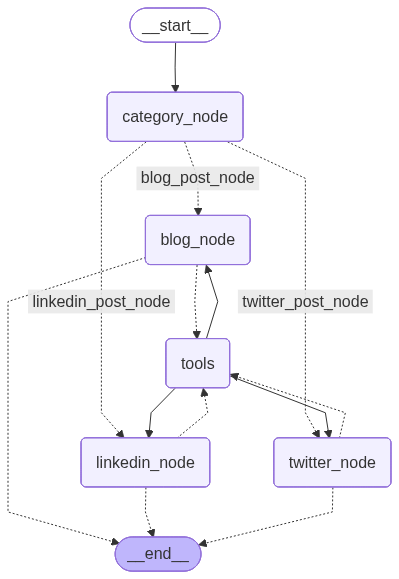

In [10]:
graph = StateGraph(AgentState)

# tools node
tools = ToolNode(tools=tool_kit)
graph.add_node("tools", tools)

graph.add_node("category_node", category_decider)

graph.add_node("twitter_node", twitter_post_node)
graph.add_node("linkedin_node", linkedin_post_node)
graph.add_node("blog_node", blog_post_node)


graph.add_edge(START, "category_node")

# router edges
graph.add_conditional_edges(
    "category_node",
    router_node,
    {
        "linkedin_post_node": "linkedin_node",
        "twitter_post_node": "twitter_node",
        "blog_post_node": "blog_node"
    }
)


# tools routing
for nodes in ["twitter_node", "linkedin_node", "blog_node"]:
    graph.add_conditional_edges(
        nodes,
        tools_condition
    )
    graph.add_edge("tools", nodes)

app = graph.compile()
app

In [11]:
response = app.invoke({
    "user_input": "I want to generate a post about the latest trends in AI as per 2026 for linkedin",
    "topic": "",
    "category": "",
    "post": "",
})

ValueError: No messages found in input state to tool_edge: {'post': '', 'user_input': 'I want to generate a post about the latest trends in AI as per 2026 for linkedin', 'topic': 'latest trends in AI 2026', 'category': 'linkedin'}

In [ ]:
print(response["post"])

In [ ]:
response